# 1. Housekeeping

In [76]:
import ciao_contrib.runtool
from ciao_contrib.runtool import *
import pandas as pd
import numpy as np
from numpy import load
import astropy 
from astropy.table import Table
from astropy.io import fits
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets as widgets

# List Folders Function
def list_folders(path):
    return [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    
# Specify path
path = '/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/'
folders = list_folders(path)
folder_list = []
for folder in folders:
    folder_list.append(folder)

# Select Set
set_widget = widgets.Dropdown(options=folder_list[:],value=folder_list[1],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', index=1, options=('dips', 'flares'), value='flares')

In [77]:
# Set ID
set_id = set_widget.value
# Folder List
data_folder_path = f'/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/{set_id}'
data_folders = sorted(list_folders(data_folder_path))
# Select Folder
folder_widget = widgets.Dropdown(options=data_folders[:],value=data_folders[0],description='Folder :',disabled=False); folder_widget

Dropdown(description='Folder :', options=('data',), value='data')

# 2. Data Extraction

In [79]:
# Set ID
set_id = set_widget.value
# Folder ID
folder_id = folder_widget.value
# File Loop
for event_filename in glob.iglob(f'{data_folder_path}/{folder_id}/acisf*regevt3.fits.gz'):
    obsid = int(event_filename.split('_')[0][-5:])
    try: 
        regionid = int(event_filename.split('_')[2][-4:])
    except: 
        regionid = int(event_filename.split('_')[3][-4:]) 
    region_filename = [region for region in glob.iglob(f'{data_folder_path}/{folder_id}/acisf*reg3.fits.gz') if str(obsid) in region and str(regionid) in region][0]
    filtered_filename = event_filename.replace(".fits", "_filtered.fits")
    try:
        ciao_contrib.runtool.dmcopy(f'{event_filename}[sky=region({region_filename})]', filtered_filename)
    except OSError: 
        print(f'{filtered_filename} already exists!')

# Initialise dataframe list of all eventfiles
list_df_events = []
# File Loop
for filename in glob.iglob(f'{data_folder_path}/{folder_id}/acisf*regevt*filtered*gz'):
  with fits.open(filename) as hdul:
      # Events
      events = hdul["Events"].data
      events_table = Table(events)
      events_cols = events.columns.names
      df_events = pd.DataFrame.from_records(events_table, columns=events_cols)
      df_events = df_events.sort_values(by=["time"])
      # GTI (Good Time Interval)
      gti = hdul["GTI"].data
      gti_table = Table(gti)
      gti_cols = gti.columns.names
      df_gti = pd.DataFrame.from_records(gti_table, columns=gti_cols)
      # Apply GTI Filter to Events
      gti_mask = np.zeros(len(df_events), dtype=bool)
      for i in range(len(df_gti)):
          start = df_gti.iloc[i]['START']
          stop = df_gti.iloc[i]['STOP']
          gti_mask |= (df_events["time"] >= start) & (df_events["time"] < stop)
      df_events = df_events[gti_mask]
      # Apply energy, pha, grade Filter to Events
      df_events = df_events[(df_events['pha']>40) & (df_events['grade']>=0) & (df_events['energy']>500) & (df_events['energy']<7000)]
      # Add obsid and region_id column (from filename)
      df_events["obsid"] = int(filename.split('_')[0][-5:])
      try: 
        df_events["region_id"] = int(filename.split('_')[2][-4:]) #need to add try except while looping 
      except: 
        df_events["region_id"] = int(filename.split('_')[3][-4:]) 
      # Append to dataframe list
      list_df_events.append(df_events)

# Combine dfs in dataframe list into one df and save in folder
df_eventfiles = pd.concat(list_df_events)
df_eventfiles.to_csv(f'{data_folder_path}/eventfiles-{set_id[0]}.csv',index=False)

# Load Properties Table
df_prop = pd.read_csv(f'{data_folder_path}/properties-{set_id[0]}.csv')
# Load Properties Table
df_events = pd.read_csv(f'{data_folder_path}/eventfiles-{set_id[0]}.csv')
# Extract important labels and input columns
df_labels = df_prop[['obsid','region_id','cnts_aper_b','cnts_aperbkg_b','src_cnts_aper_b','flux_aper_b','hard_hm','hard_hs','hard_ms','var_prob_b','var_prob_h','var_prob_m','var_prob_s']]
df_input = df_events[['obsid','region_id','time','energy','chipx','chipy']]
# Make Sure Eventfile Table only includes information contained in Properties Table and vice versa
df_labels['obsreg_id'] = df_labels['obsid'].astype(str) + '_' + df_labels['region_id'].astype(str)
df_input['obsreg_id'] = df_input['obsid'].astype(str) + '_' + df_input['region_id'].astype(str)
df_labels = df_labels[df_labels['obsreg_id'].isin(df_input['obsreg_id'].unique())]
df_input = df_input[df_input['obsreg_id'].isin(df_labels['obsreg_id'].unique())]
# Save ungrouped tables
df_labels.to_csv(f'{data_folder_path}/labels-{set_id[0]}.csv',index=False)
df_input.to_csv(f'{data_folder_path}/inputs-{set_id[0]}.csv',index=False)

/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10468_001N021_r0185_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10822_000N021_r0185_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10996_000N020_r0005_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf02833_001N020_r0053_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10922_001N021_r0185_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-202

/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_1929/2381931362.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels['obsreg_id'] = df_labels['obsid'].astype(str) + '_' + df_labels['region_id'].astype(str)
/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_1929/2381931362.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['obsreg_id'] = df_input['obsid'].astype(str) + '_' + df_input['region_id'].astype(str)


# 3. Lightcurves and 2D Histograms

/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_1929/112636527.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delta_time"] = df['time'].diff()


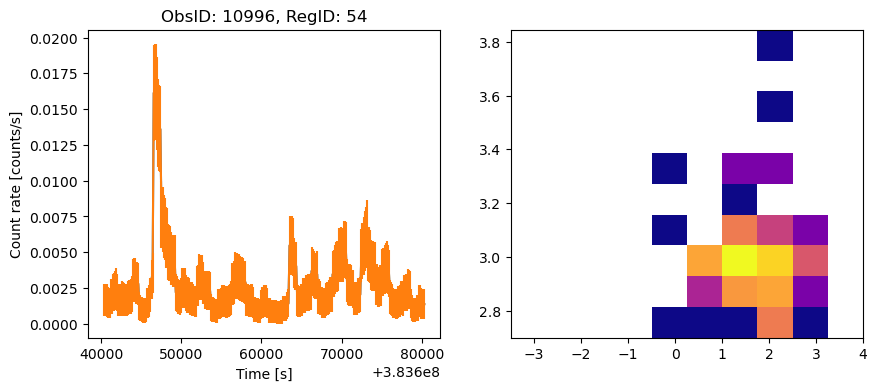

read ARF file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10996_000N021_r0005_arf3.fits
read RMF file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10996_000N021_r0005_rmf3.fits
read background file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10996_000N022_r0005_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


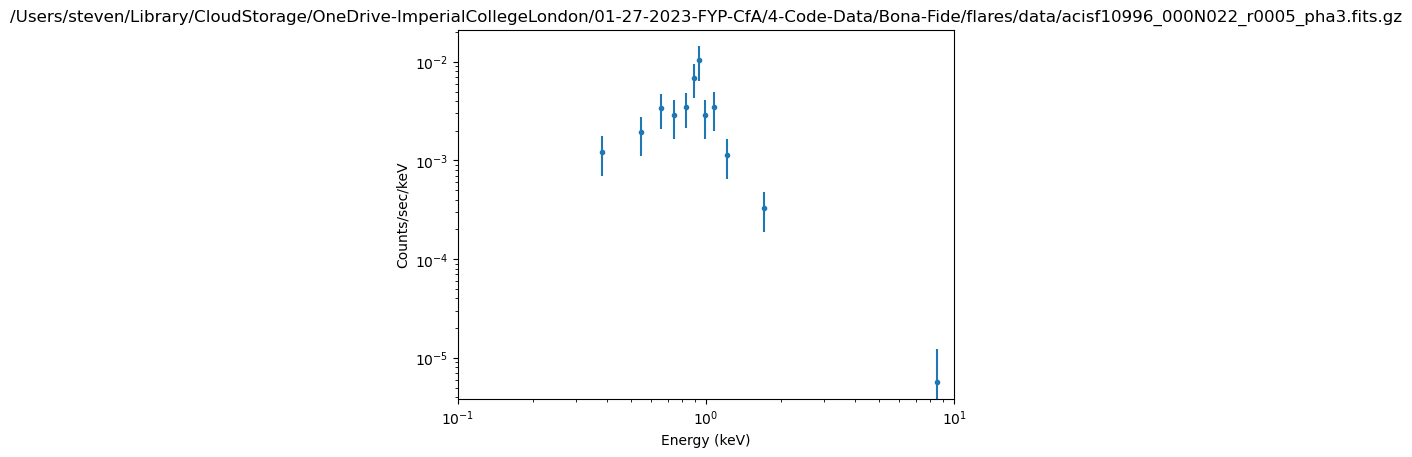

/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_1929/112636527.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delta_time"] = df['time'].diff()


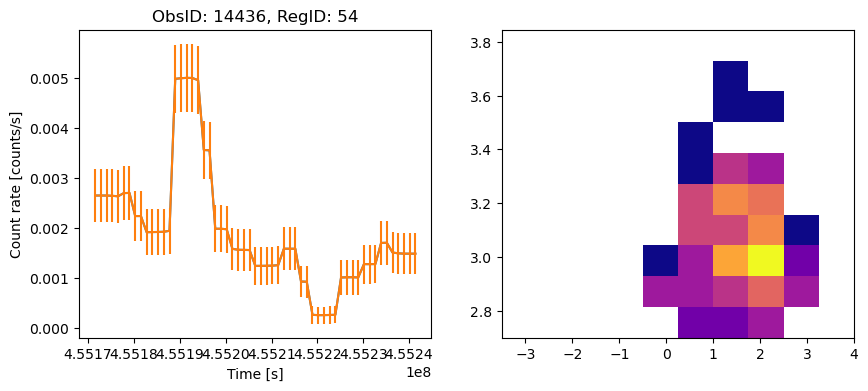

read ARF file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf14436_001N021_r0054_arf3.fits
read RMF file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf14436_001N021_r0054_rmf3.fits
read background file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf14436_001N022_r0054_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


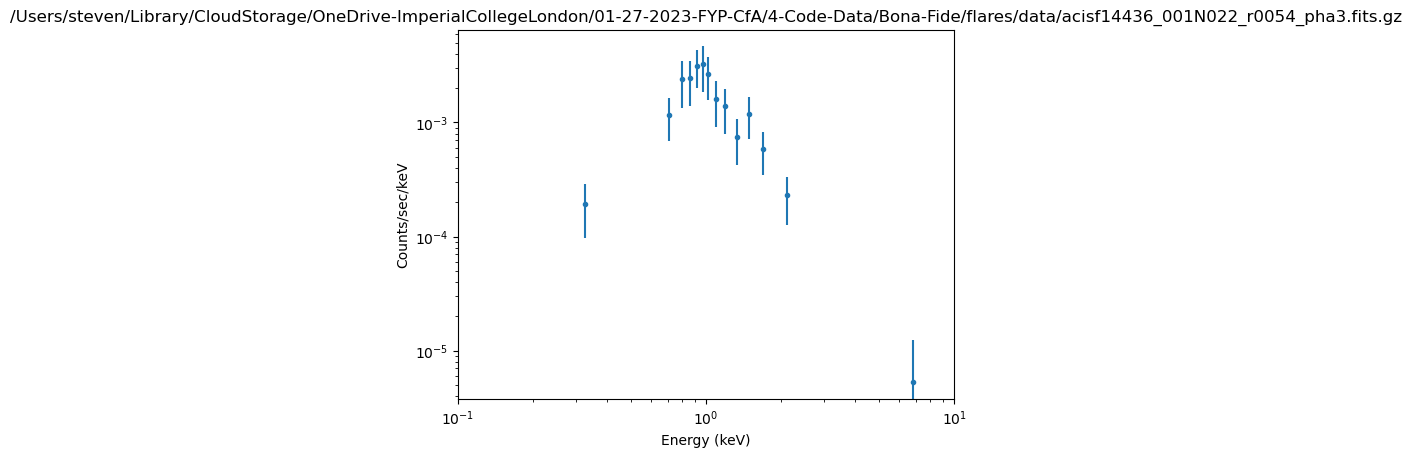

/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_1929/112636527.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delta_time"] = df['time'].diff()


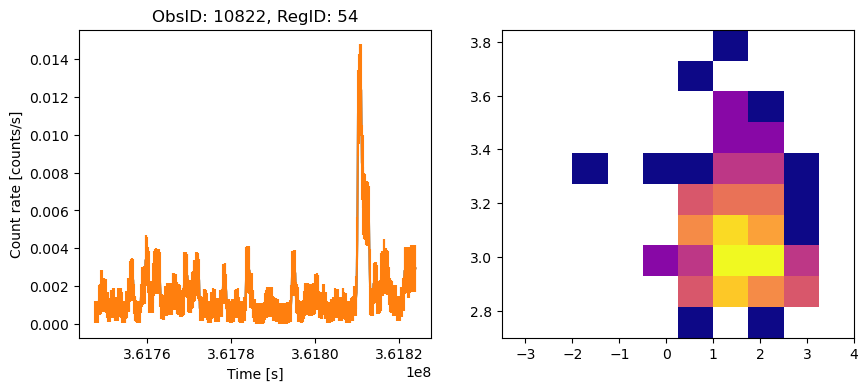

read ARF file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10822_000N022_r0185_arf3.fits
read RMF file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10822_000N022_r0185_rmf3.fits
read background file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10822_000N023_r0185_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


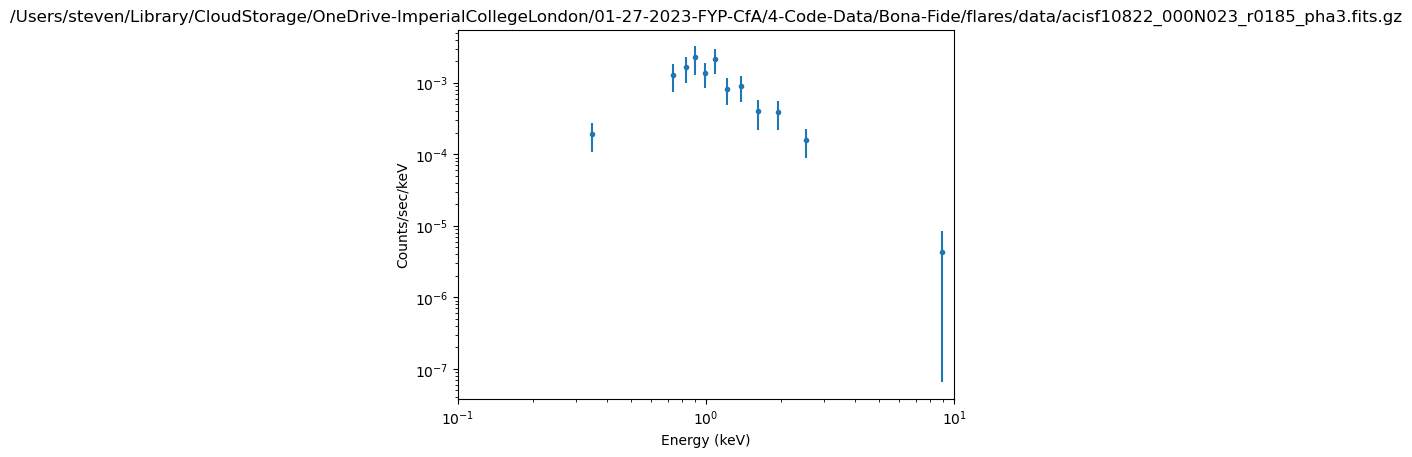

/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_1929/112636527.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delta_time"] = df['time'].diff()


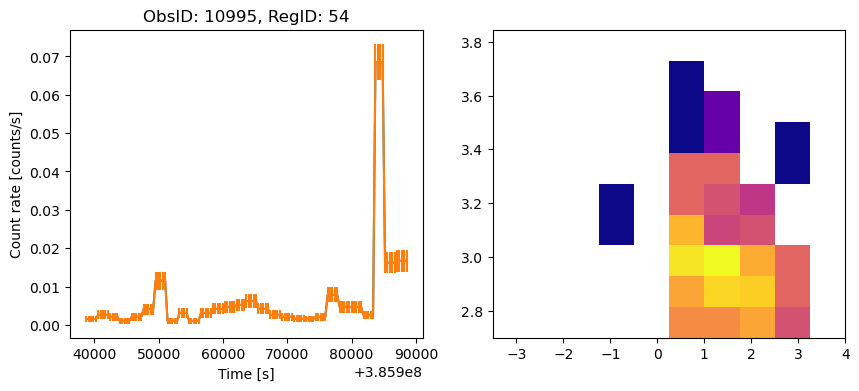

read ARF file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10995_001N022_r0021_arf3.fits
read RMF file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10995_001N022_r0021_rmf3.fits
read background file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf10995_001N023_r0021_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


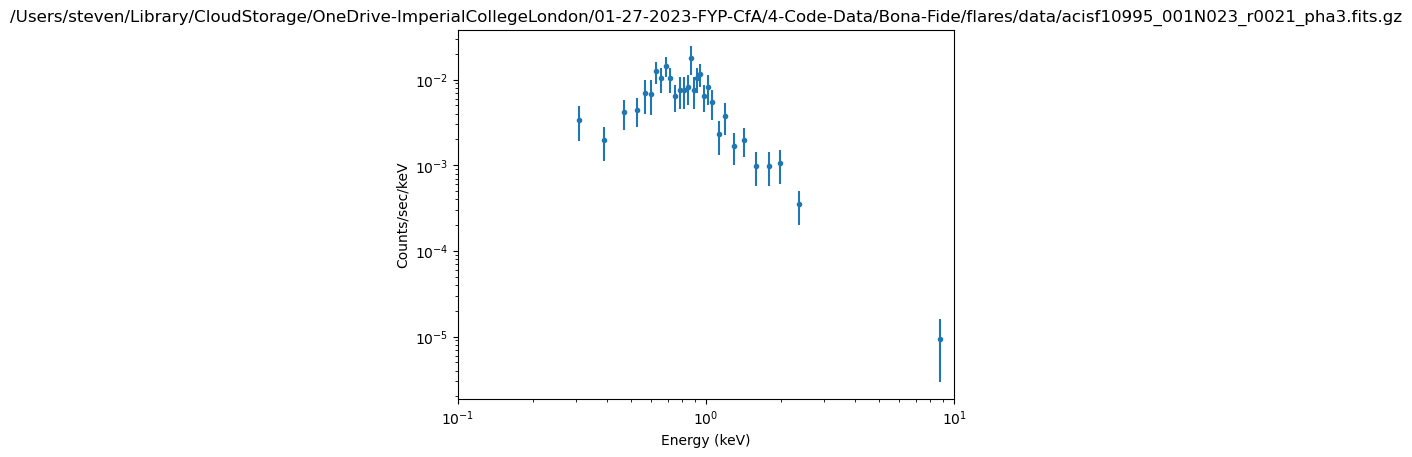

/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_1929/112636527.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delta_time"] = df['time'].diff()


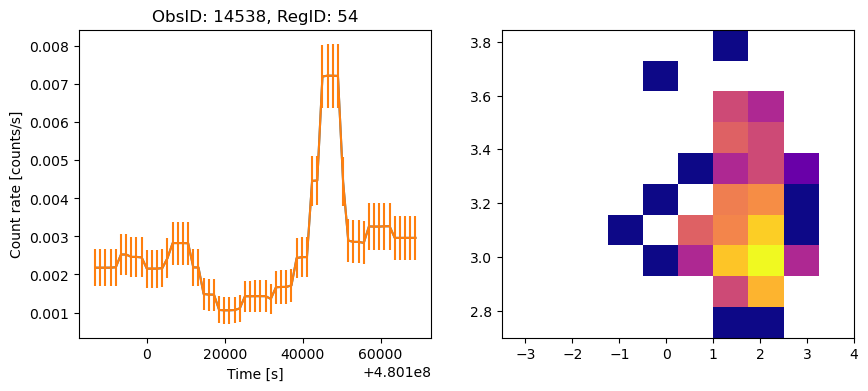

read ARF file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf14538_001N022_r0005_arf3.fits
read RMF file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf14538_001N022_r0005_rmf3.fits
read background file /Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Bona-Fide/flares/data/acisf14538_001N023_r0005_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:7.9862 Energy (keV)
dataset 1: 0.511:7.9862 -> 0.292:7.9862 Energy (keV)


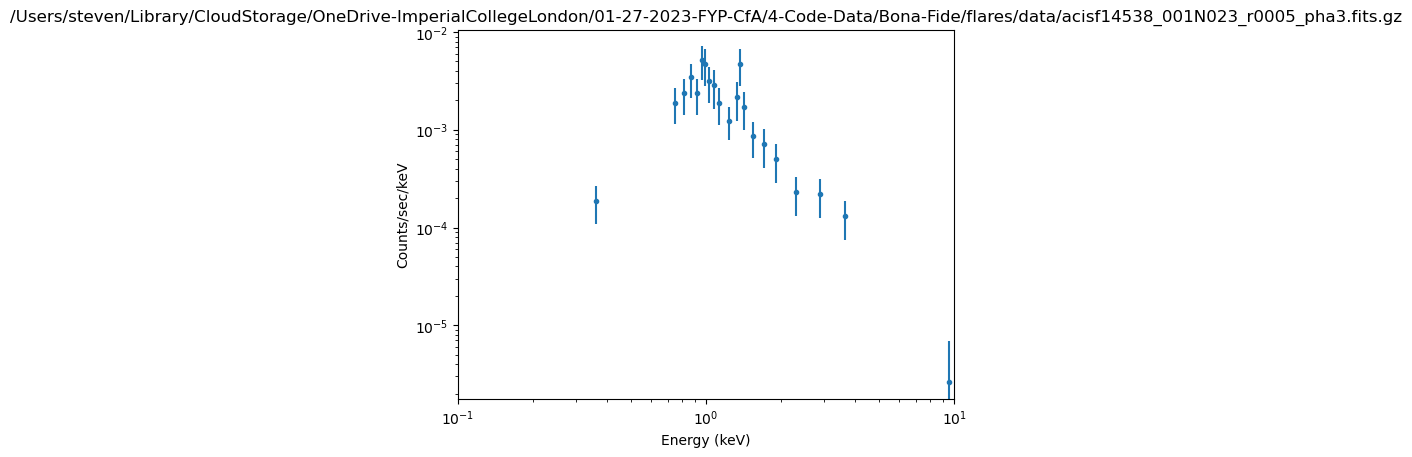

In [86]:
from matplotlib.colors import LogNorm
from sherpa.astro import ui

# Set ID
set_id = set_widget.value
# Folder ID
folder_id = folder_widget.value
#Settings
dt_axis_min = -3.5
dt_axis_max = 4
nbins_dt = 10
nbins_E = 10

df_labels = pd.read_csv(f'{data_folder_path}/labels-{set_id[0]}.csv')
df_inputs = pd.read_csv(f'{data_folder_path}/inputs-{set_id[0]}.csv')


# Initialise features, labels and ids lists
unique_ids = df_inputs["obsreg_id"].unique()
x_features = []
y_labels = []
id_pass = []

# Loop over all eventfiles
for id in unique_ids[:5]:
    # Filter to eventfile and labels according to unique identifier
    df = df_inputs[df_inputs['obsreg_id']==id]
    dfy = df_labels[df_labels['obsreg_id'] == id]
    # Get IDs
    obsid = id.split('_')[0]
    regid = id.split('_')[1]
    # Add delta_time column
    df["delta_time"] = df['time'].diff()
    # Remove first row as delta_time = nan
    df = df[df["delta_time"].notna()]
    # Add a constant value "pseudo-count" 0.1 to delta_time = 0 
    df["delta_time"] = df["delta_time"].apply(lambda dt: np.where(dt == 0, dt + 0.1, dt))
    # Eventfile length, duration and energy range
    N = len(df) 
    T = max(df["time"])-min(df["time"])
    E = max(df["energy"])-min(df["energy"])
    # Add dt column
    df["dt"] = np.log10(100 * N * df["delta_time"]/T)
    # Add E column
    df["E"] = np.log10(df["energy"])

    # Lightcurve
    fig, (ax_lc,hist) = plt.subplots(1, 2,figsize=(10, 4))

    lc_filename = [lcurve for lcurve in glob.iglob(f'{data_folder_path}/{folder_id}/acisf*lc3.fits.gz') if str(obsid) in lcurve and str(regid) in lcurve][0]
    pha_filename = [spec for spec in glob.iglob(f'{data_folder_path}/{folder_id}/acisf*pha3.fits.gz') if str(obsid) in spec and str(regid) in spec][0]

    with fits.open(lc_filename) as hdul_lc:
        lc3 = hdul_lc[1].data
        bg3 = hdul_lc[2].data
        ax_lc.plot(lc3['Time'],lc3['COUNT_RATE'])
        ax_lc.set(xlabel='Time [s]', ylabel='Count rate [counts/s]')
        ax_lc.set_title(f'ObsID: {obsid}, RegID: {regionid}')
        ax_lc.errorbar(lc3['Time'],lc3['COUNT_RATE'],lc3['COUNT_RATE_ERR'])

    # Create histogram representation
    #hist = plt.hist2d(df["dt"],df["E"],range = [[dt_axis_min, dt_axis_max],[np.log10(500.), np.log10(7000.)]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma', density = True) 
    hist = plt.hist2d(df["dt"],df["E"],range = [[dt_axis_min, dt_axis_max],[np.log10(500.), np.log10(7000.)]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma') 
    # Create features and labels 
    #x = np.log10(0.01+hist[0]) # Apply log to smaller counts more visible and add "pseudo-count" = 0.01 NOT NECESSARY
    x = hist[0]
    y = dfy[['cnts_aper_b','cnts_aperbkg_b','src_cnts_aper_b','flux_aper_b','hard_hm','hard_hs','hard_ms','var_prob_b','var_prob_h','var_prob_m',	'var_prob_s']].to_numpy()
    # Append features, labels and ids lists
    x_features.append(x)
    y_labels.append(y)
    id_pass.append(id)

    plt.show()
    
    ui.load_pha(pha_filename)
    ui.ignore('0.:0.5,8.0:')
    ui.subtract()
    ui.notice_id(1,0.3,7.)
    ui.group_counts(10)
    ui.set_ylog()
    ui.set_xlog()
    ui.plot_data()
    plt.xlim(1E-1,10)  
    plt.show()
      
    